In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import openslide
from openslide import open_slide
import large_image
import pandas as pd

In [2]:
# Get path to raw data 
main_directory = os.path.dirname(os.getcwd())
os.chdir(main_directory + '/data/raw/svs_files')
svs_data_directory = os.getcwd()
svs_files = os.listdir(svs_data_directory)

In [4]:
# Load in .svs file (using open_slide)
svs_file = svs_files[0]
slide = open_slide(svs_file)
print(svs_file)

TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A.svs


In [4]:
# Get slide dimensions as (width, height)
[width, height] = slide.dimensions
print(f"Image width: {width} \nImage height: {height}")

slide_props = slide.properties
print(slide_props)

print(f"Case ID: {slide_props['aperio.Filename']}")
print("Pixel size of X in µm is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in µm is:", slide_props['openslide.mpp-y'])

Image width: 134231 
Image height: 93580
<_PropertyMap {'aperio.AppMag': '40', 'aperio.DSR ID': 'resc3-dsr2', 'aperio.Date': '01/10/11', 'aperio.DisplayColor': '0', 'aperio.Exposure Scale': '0.000001', 'aperio.Exposure Time': '109', 'aperio.Filename': 'TCGA-A2-A0SY-01Z-00-DX1', 'aperio.Focus Offset': '0.000000', 'aperio.ICC Profile': 'ScanScope v1', 'aperio.ImageID': '45922', 'aperio.Left': '19.192802', 'aperio.LineAreaXOffset': '0.003267', 'aperio.LineAreaYOffset': '-0.003095', 'aperio.LineCameraSkew': '0.001071', 'aperio.MPP': '0.2480', 'aperio.OriginalHeight': '93680', 'aperio.OriginalWidth': '139872', 'aperio.Parmset': 'GOG136 on RESBPCLACIE01', 'aperio.ScanScope ID': 'SS1511CNTLR', 'aperio.StripeWidth': '992', 'aperio.Time': '17:29:52', 'aperio.Title': 'TCGA-A2-A0SY-01Z-00-DX1', 'aperio.Top': '24.750303', 'aperio.User': '23e59d7b-628e-431d-adef-2a40a2ce126e', 'openslide.comment': 'Aperio Image Library v10.2.24\r\n139872x93680 [0,100 134231x93580] (240x240) JPEG/RGB Q=30|AppMag = 4

Each level is downsampled by an amount of:  (1.0, 4.00004470006258, 16.001443204809114, 64.00958799196559)


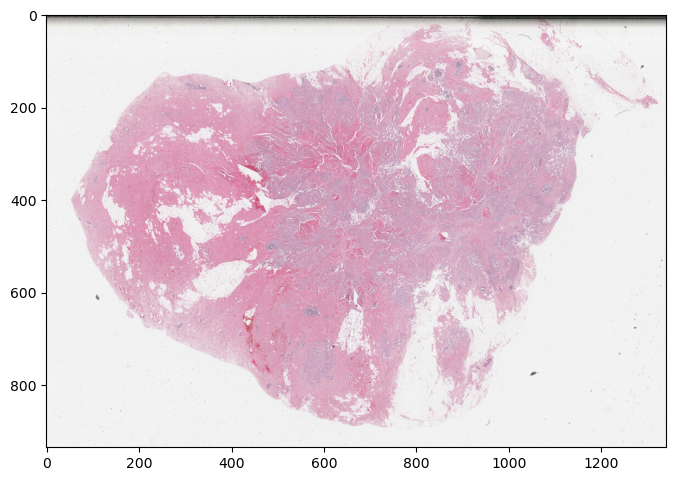

In [5]:
# Get a thumbnail of the image and visualise
slide_thumb_1000 = slide.get_thumbnail(size=(width/100, height/100))

# Convert thumbnail to numpy array
slide_thumb_1000_np = np.array(slide_thumb_1000)
plt.figure(figsize=(8,8))
plt.imshow(slide_thumb_1000_np) 
# plt.axis('off')

# By how much are levels downsampled from the original image?
factors = slide.level_downsamples
print("Each level is downsampled by an amount of: ", factors)

In [7]:
# extract levels and downsampling factors of each slide
df = pd.DataFrame()
col_names = ['File_name', 'Level0_factor', 'Level1_factor', 'Level2_factor', 'Level3_factor', 'Level0_height', 'Level0_width',
            'Level1_height', 'Level1_width', 'Level2_height', 'Level2_width', 'Level3_height', 'Level3_width']
df_data = []
for svs in svs_files:
    slide = open_slide(svs)
    slide_props = slide.properties
    levels = len(slide.level_dimensions)
    factors = np.array(slide.level_downsamples)
    data = [slide_props['aperio.Filename']]
    for r in range(levels):
        data.append(factors[r])
    data.extend([slide_props['openslide.level[0].height'], slide_props['openslide.level[0].width'], 
                slide_props['openslide.level[1].height'], slide_props['openslide.level[1].width'],
                slide_props['openslide.level[2].height'], slide_props['openslide.level[2].width'],
                slide_props['openslide.level[3].height'], slide_props['openslide.level[3].width']])
    df_data.append(data)
df = pd.DataFrame(df_data, columns=col_names)
df

File_name  Level0_factor  Level1_factor  Level2_factor  \
0  TCGA-A2-A0SY-01Z-00-DX1            1.0       4.000045      16.001443   
1  TCGA-A2-A0CX-01Z-00-DX1            1.0       4.000133      16.001814   
2  TCGA-C8-A12Q-01Z-00-DX1            1.0       4.000095      16.001398   
3  TCGA-A2-A0SW-01Z-00-DX1            1.0       4.000073      16.001832   
4  TCGA-A2-A0EY-01Z-00-DX1            1.0       4.000053      16.001258   
5                    46194            1.0       4.000037      16.001438   

   Level3_factor Level0_height Level0_width Level1_height Level1_width  \
0      64.009588         93580       134231         23395        33557   
1      32.003627         81606        71819         20401        17954   
2      32.002796         62955        76160         15738        19040   
3      32.005765         85033       121855         21258        30463   
4      32.002516         91820       112995         22955        28248   
5      32.005217         90504       109434         22626        27358   

  Level2_height Level2_width Level3_height Level3_width  
0          5848         8389          1462         2097  
1          5100         4488          2550         2244  
2          3934         4760          1967         2380  
3          5314         7615          2657         3807  
4          5738         7062          2869         3531  
5          5656         6839          2828         3419

In [22]:
dims = slide.level_dimensions
print(f'Slide dimensions: {dims}')
num_levels = len(dims)
print("Number of levels in this image are:", num_levels)

Number of levels in this image are: 4


Text(0.5, 0.632, 'Magnification: 40x')

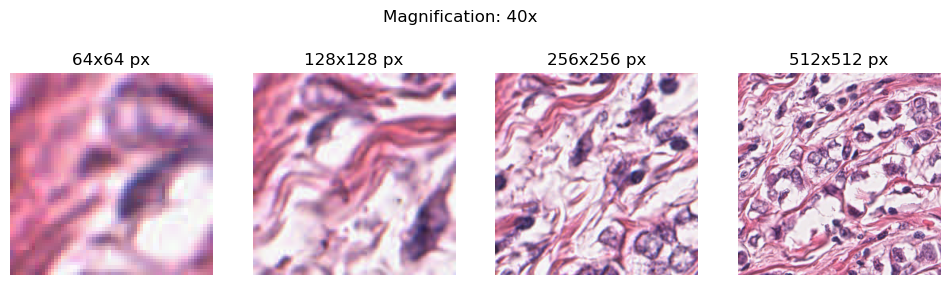

In [26]:
# Extract regions with top left pixel at (50000, 50000) and of different region sizes
tile64 = slide.read_region((50000,50000), 0, (64,64))
tile128 = slide.read_region((50000,50000), 0, (128,128))
tile256 = slide.read_region((50000,50000), 0, (256,256))
tile512 = slide.read_region((50000,50000), 0, (512,512))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,12))
ax1.imshow(tile64); ax1.axis('off'); ax1.set_title("64x64 px")
ax2.imshow(tile128); ax2.axis('off'); ax2.set_title("128x128 px")
ax3.imshow(tile256); ax3.axis('off'); ax3.set_title("256x256 px")
ax4.imshow(tile512); ax4.axis('off'); ax4.set_title("512x512 px")
fig.suptitle("Magnification: " + str(40) + "x", y=0.632)

Text(0.5, 0.632, 'Magnification: 10x')

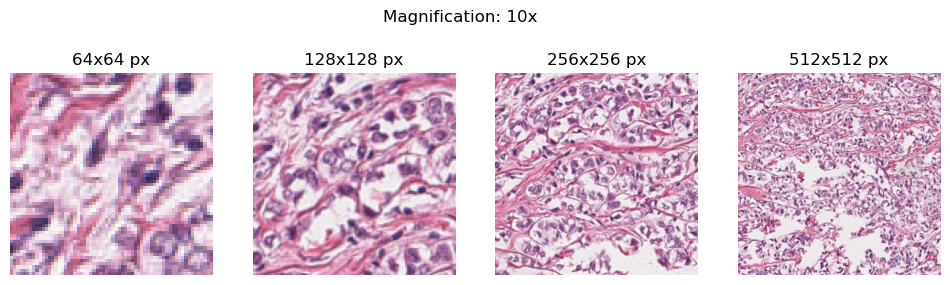

In [28]:
# Extract regions with top left pixel at (50000, 50000) and of different region sizes
tile64 = slide.read_region((50000,50000), 1, (64,64))
tile128 = slide.read_region((50000,50000), 1, (128,128))
tile256 = slide.read_region((50000,50000), 1, (256,256))
tile512 = slide.read_region((50000,50000), 1, (512,512))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,12))
ax1.imshow(tile64); ax1.axis('off'); ax1.set_title("64x64 px")
ax2.imshow(tile128); ax2.axis('off'); ax2.set_title("128x128 px")
ax3.imshow(tile256); ax3.axis('off'); ax3.set_title("256x256 px")
ax4.imshow(tile512); ax4.axis('off'); ax4.set_title("512x512 px")
fig.suptitle("Magnification: " + str(10) + "x", y=0.632)

Text(0.5, 0.632, 'Magnification: 2.5x')

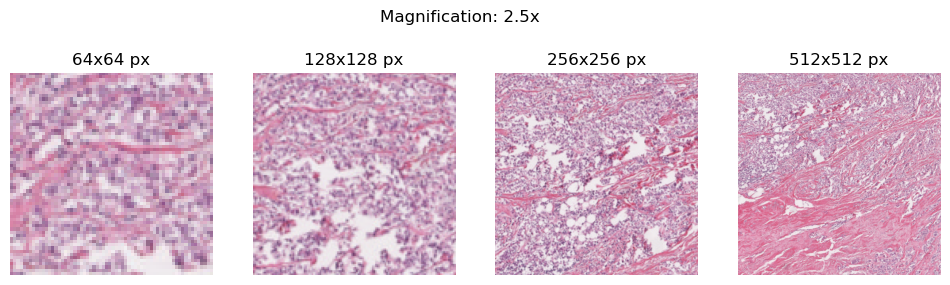

In [29]:
# Extract regions with top left pixel at (50000, 50000) and of different region sizes
tile64 = slide.read_region((50000,50000), 2, (64,64))
tile128 = slide.read_region((50000,50000), 2, (128,128))
tile256 = slide.read_region((50000,50000), 2, (256,256))
tile512 = slide.read_region((50000,50000), 2, (512,512))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,12))
ax1.imshow(tile64); ax1.axis('off'); ax1.set_title("64x64 px")
ax2.imshow(tile128); ax2.axis('off'); ax2.set_title("128x128 px")
ax3.imshow(tile256); ax3.axis('off'); ax3.set_title("256x256 px")
ax4.imshow(tile512); ax4.axis('off'); ax4.set_title("512x512 px")
fig.suptitle("Magnification: " + str(2.5) + "x", y=0.632)

Text(0.5, 1.0, '10X upsized to 256')

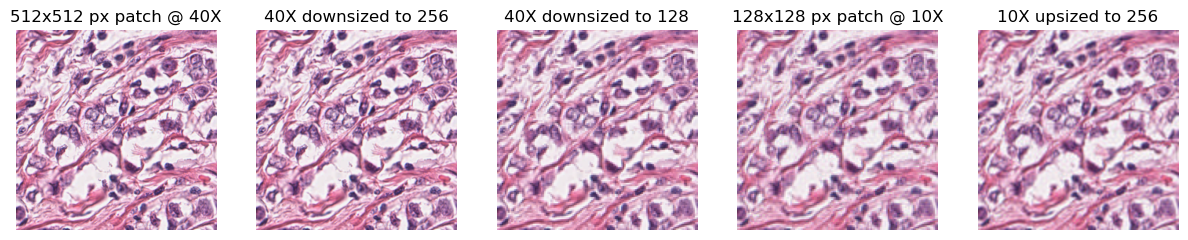

In [43]:
tile40x = slide.read_region((50000,50000), 0, (512,512))
tile10x = slide.read_region((50000,50000), 1, (128,128))

# Resize larger tile to a smaller image
downsized256 = tile40x.resize([256, 256])
downsized128 = tile40x.resize([128, 128])
upsized256 = tile10x.resize([256, 256])

# Compare extracted patches
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,165))
ax1.imshow(tile40x); ax1.axis('off'); ax1.set_title("512x512 px patch @ 40X")
ax2.imshow(downsized256); ax2.axis('off'); ax2.set_title("40X downsized to 256")
ax3.imshow(downsized128); ax3.axis('off'); ax3.set_title("40X downsized to 128")
ax4.imshow(tile10x); ax4.axis('off'); ax4.set_title("128x128 px patch @ 10X")
ax5.imshow(upsized256); ax5.axis('off'); ax5.set_title("10X upsized to 256")


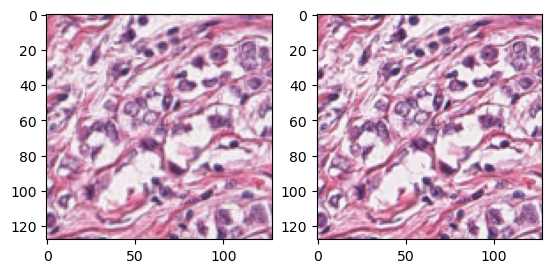

In [40]:
d = tile40x.resize([128, 128])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(tile10x)
ax2.imshow(d)

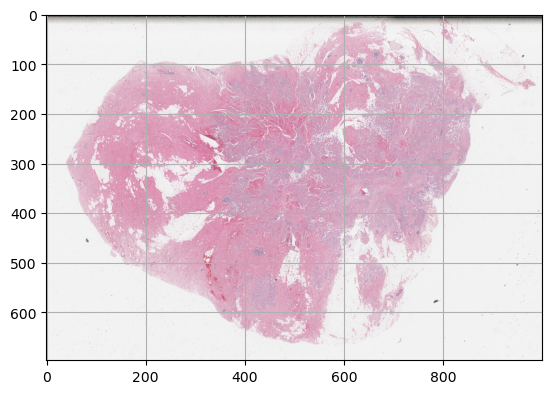

In [45]:
# Work on visualising grid over original image ...
plt.imshow(slide.get_thumbnail(size=(1000, 1000)))
plt.grid()

In [111]:
def visualise_grid(slide, gridLineWidth, level):
    
    # Extract image dimensions at specified level
    h = int(slide_props['openslide.level[' + str(level) + '].height'])
    w = int(slide_props['openslide.level[' + str(level) + '].width'])
    # Extract whole image at specified level
    level_img = slide.read_region((0,0), level, (w, h))

    # Define grid
    grid = np.zeros([h, w]); grid_img = np.array(level_img)[:, :, :3]
    num_horz_lines = h//gridLineWidth; num_vert_lines = w//gridLineWidth
    # Draw vertical lines on grid
    for i in range(1, num_vert_lines+1):
        line = i*gridLineWidth
        if line <= w: grid[:, line] = 1
    # Draw horizontal lines on grid
    for j in range(1, num_horz_lines+1):
        line = j*gridLineWidth
        if line <= h: grid[line, :] = 1

    # Draw grid onto image
    for i in range(h):
        for j in range(w):
            if grid[i][j] == 1:
                grid_img[i][j][:] = [0, 0, 0]
    return grid_img

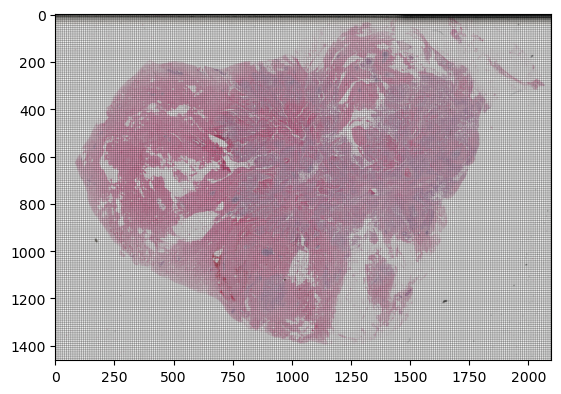

In [113]:
grid_img = visualise_grid(slide, 8, level=3)
plt.imshow(grid_img)

(1462, 2097, 3)


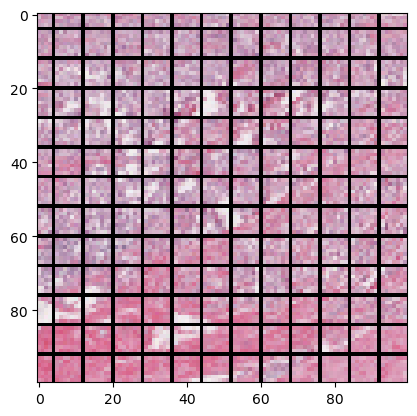

In [125]:
# Zoom into grid image to show smaller area
print(grid_img.shape)
zoomed_img = grid_img[780:880,780:880, :]
plt.imshow(zoomed_img)

Text(0.5, 0.94, 'View level of detail ')

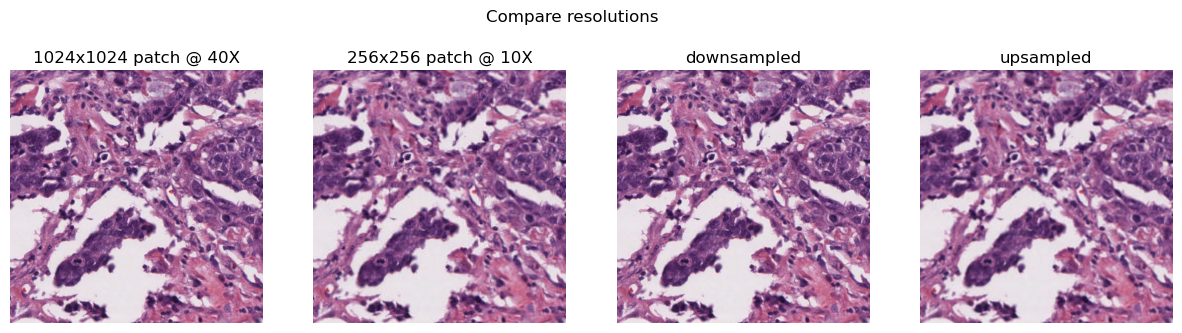

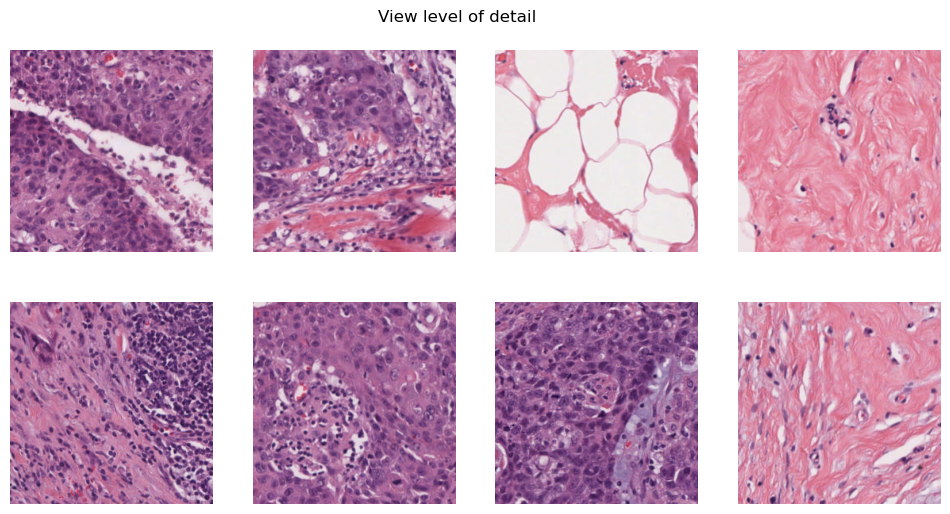

In [16]:
# Patch size used by Coudray et al. AND Farahmand et al.
# (512x512 in 20X magnification)
# equivalent to 256x256 in 10X magnification or 1024x1024 in 40X magnification

# example patches to show level of detail captured
t_at_40 = slide.read_region((50000,50000), 0, (1024,1024))
t_at_10 = slide.read_region((50000,50000), 1, (256,256))

# Compare extracted patches
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))
ax1.imshow(t_at_40); ax1.axis('off'); ax1.set_title("1024x1024 patch @ 40X")
ax2.imshow(t_at_10); ax2.axis('off'); ax2.set_title("256x256 patch @ 10X")
ax3.imshow(t_at_40.resize([512, 512])); ax3.axis('off'); ax3.set_title("downsampled")
ax4.imshow(t_at_10.resize([512, 512])); ax4.axis('off'); ax4.set_title("upsampled")
fig.suptitle("Compare resolutions", y=0.62)

# Compare extracted patches
fig, axs = plt.subplots(2, 4, figsize=(12,6))
axs[0, 0].imshow(slide.read_region((20000,50000), 1, (256,256))); 
axs[0, 1].imshow(slide.read_region((28309,65892), 1, (256,256))); 
axs[0, 2].imshow(slide.read_region((97203,50000), 1, (256,256))); 
axs[0, 3].imshow(slide.read_region((78239,18902), 1, (256,256))); 
axs[1, 0].imshow(slide.read_region((13000,50000), 1, (256,256))); 
axs[1, 1].imshow(slide.read_region((28309,48099), 1, (256,256)));
axs[1, 2].imshow(slide.read_region((52000,18000), 1, (256,256)));
axs[1, 3].imshow(slide.read_region((75000,18902), 1, (256,256)));
[axi.set_axis_off() for axi in axs.ravel()]
# plt.subplots_adjust(wspace=0.05, hspace=0.001)
fig.suptitle("View level of detail ", y=0.94)
